**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика
F1( 𝛽  = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

In [221]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

**Подключение библиотек и скриптов**

In [222]:
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [223]:
# from google.colab import files
# uploaded = files.upload()

In [224]:
import warnings
warnings.filterwarnings('ignore')

In [225]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [226]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
  
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [227]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
  
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [228]:
def replacing_outliers_with_a_median(df, name_feature):
  
    q1 = df[name_feature].quantile(0.25)
    q3 = df[name_feature].quantile(0.75)
    k = 1.5
    iqr = q3 - q1
    condition_1 = df[name_feature] < (q1 - (k * iqr))
    condition_2 = df[name_feature] > (q3 + (k * iqr))
    df.loc[(condition_1 | condition_2), name_feature] = df[name_feature].median()

    return df

In [229]:
def percentage_missing(df, name_feature1, name_feature2, name_feature3, name_feature4, name_feature5):

  annual_income = (df[name_feature1].isna().sum() / df.shape[0]) * 100

  years_in_current_job = (df[name_feature2].isna().sum() / df.shape[0]) * 100

  months_since_last_delinquent = (df[name_feature3].isna().sum() / df.shape[0]) * 100

  bankruptcies = (df[name_feature4].isna().sum() / df.shape[0]) * 100

  credit_score = (df[name_feature5].isna().sum() / df.shape[0]) * 100

  print(f'Missing data in feature "Annual Income" are {annual_income:.2f}%')
  print(f'Missing data in feature "Years in current job" are {years_in_current_job:.2f}%')
  print(f'Missing data in feature "Months since last delinquent" are {months_since_last_delinquent:.2f}%')
  print(f'Missing data in feature "Bankruptcies" are {bankruptcies:.2f}%')
  print(f'Missing data in feature "Credit Score" are {credit_score:.2f}%')

**Путь к директориям и файлам**

In [230]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

# output
PREP_DATASET_PATH = 'course_project_train_prep.csv'
PREP_TEST_DATASET_PATH = 'course_project_test_prep.csv'

TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'final_model.pkl'

# predictions
PREDICT_TEST_PATH = 'ASPushkarev_predictions.csv'

**Загрузка данных**

In [231]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2959,Rent,1206158.0,2 years,0.0,13.0,14.8,45056.0,0.0,14.0,0.0,other,Short Term,135146.0,24548.0,8131.0,736.0,0
1462,Home Mortgage,NaN,6 years,0.0,11.0,12.7,906400.0,0.0,NaN,0.0,debt consolidation,Short Term,217184.0,408614.0,20421.0,NaN,0
1545,Rent,NaN,2 years,0.0,5.0,17.0,415888.0,0.0,NaN,0.0,debt consolidation,Short Term,559306.0,255740.0,12845.0,NaN,0
3285,Home Mortgage,1316567.0,3 years,0.0,17.0,14.5,307252.0,0.0,13.0,0.0,business loan,Long Term,261338.0,135318.0,28087.0,659.0,0
2776,Rent,745446.0,NaN,0.0,7.0,17.1,200816.0,1.0,NaN,1.0,debt consolidation,Short Term,24354.0,9367.0,4299.0,738.0,0


In [232]:
df_train.shape

(7500, 17)

In [233]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [234]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Приведение типов**

In [235]:
for colname in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems']:
  df_train[colname] = df_train[colname].astype(int)

In [236]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                         int64
Number of Open Accounts           int64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems         int64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Обзор целевой переменной**

In [237]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

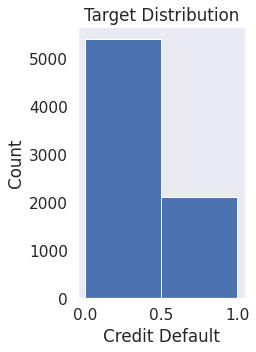

In [238]:
plt.figure(figsize = (3, 5))
df_train['Credit Default'].hist(bins=2, grid=False)
plt.ylabel('Count')
plt.xlabel('Credit Default')
plt.title('Target Distribution')
plt.show()

**Обзор количественных признаков**

In [239]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [240]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Обработка пропусков**

In [241]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Подсчитаем пропуски в процентах**

In [242]:
percentage_missing(df_train, 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score')

Missing data in feature "Annual Income" are 20.76%
Missing data in feature "Years in current job" are 4.95%
Missing data in feature "Months since last delinquent" are 54.41%
Missing data in feature "Bankruptcies" are 0.19%
Missing data in feature "Credit Score" are 20.76%


**Заполним медианой пропуски в числовых признаках**

In [243]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()

df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] \
           = df_train['Months since last delinquent'].median()

df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = df_train['Bankruptcies'].median()

df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] = df_train['Credit Score'].median()

**Заполним модой пропуски в категориальных признаках**

In [244]:
df_train['Years in current job'].mode()[0]

'10+ years'

In [245]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job']

0       NaN
22      NaN
24      NaN
58      NaN
60      NaN
       ... 
7368    NaN
7409    NaN
7413    NaN
7439    NaN
7498    NaN
Name: Years in current job, Length: 371, dtype: object

In [246]:
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = df_train['Years in current job'].mode()[0]

In [247]:
df_train['Years in current job'].isna().sum()

0

**Ещё раз проверим на пропуски наш датасет**

In [248]:
df_train.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

**Поработаем с выбросами**

Text(0.5, 1.0, 'Outlier analysis for Annual Income')

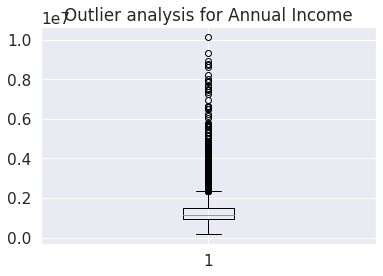

In [249]:
plt.boxplot(df_train['Annual Income'])
plt.title('Outlier analysis for Annual Income')

In [250]:
df_train['Annual Income'].value_counts()

1168386.0    1558
1161660.0       4
1058376.0       4
1043651.0       4
969475.0        4
             ... 
1272316.0       1
712082.0        1
695476.0        1
678889.0        1
402192.0        1
Name: Annual Income, Length: 5478, dtype: int64

In [251]:
replacing_outliers_with_a_median(df_train, 'Annual Income')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,1,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,35.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,1,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,1,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,1778920.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [252]:
df_train['Annual Income'].value_counts()

1168386.0    2074
1161660.0       4
969475.0        4
1058376.0       4
1043651.0       4
             ... 
1788546.0       1
1399920.0       1
801116.0        1
619913.0        1
402192.0        1
Name: Annual Income, Length: 4973, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Annual Income')

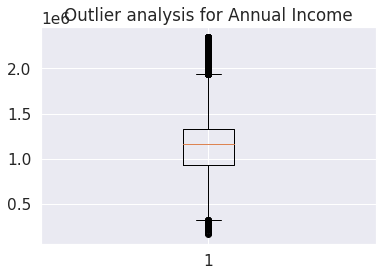

In [253]:
plt.boxplot(df_train['Annual Income'])
plt.title('Outlier analysis for Annual Income')

Text(0.5, 1.0, 'Outlier analysis for Tax Liens')

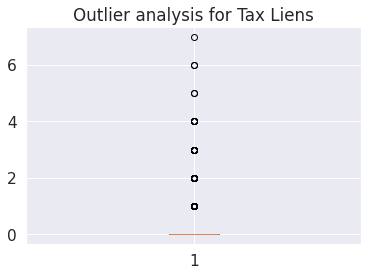

In [254]:
plt.boxplot(df_train['Tax Liens'])
plt.title('Outlier analysis for Tax Liens')

In [255]:
df_train['Tax Liens'].value_counts()

0    7366
1      83
2      30
3      10
4       6
6       2
5       2
7       1
Name: Tax Liens, dtype: int64

In [256]:
replacing_outliers_with_a_median(df_train, 'Tax Liens')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,1,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,35.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,1,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,1,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,1778920.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [257]:
df_train['Tax Liens'].value_counts()

0    7500
Name: Tax Liens, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Tax Liens')

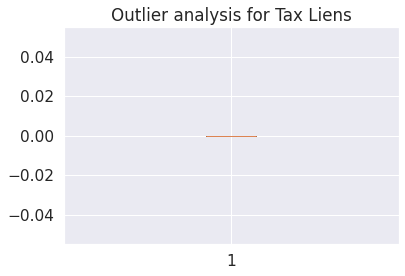

In [258]:
plt.boxplot(df_train['Tax Liens'])
plt.title('Outlier analysis for Tax Liens')

Text(0.5, 1.0, 'Outlier analysis for Number of Open Accounts')

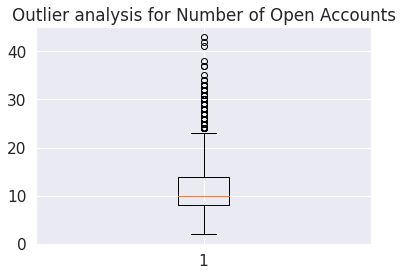

In [259]:
plt.boxplot(df_train['Number of Open Accounts'])
plt.title('Outlier analysis for Number of Open Accounts')

In [260]:
df_train['Number of Open Accounts'].value_counts()

9     728
11    692
10    677
8     638
7     613
12    562
6     504
13    465
14    420
5     325
15    313
16    265
17    232
4     212
18    143
19    139
3      95
20     93
21     78
23     59
24     50
22     49
25     32
2      28
28     14
27     14
26     12
30     11
29     10
32      6
33      6
31      6
34      2
37      2
43      1
41      1
38      1
35      1
42      1
Name: Number of Open Accounts, dtype: int64

In [261]:
replacing_outliers_with_a_median(df_train, 'Number of Open Accounts')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,1,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,35.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,1,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,1,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,1778920.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [262]:
df_train['Number of Open Accounts'].value_counts()

10    847
9     728
11    692
8     638
7     613
12    562
6     504
13    465
14    420
5     325
15    313
16    265
17    232
4     212
18    143
19    139
3      95
20     93
21     78
23     59
22     49
2      28
Name: Number of Open Accounts, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Number of Open Accounts')

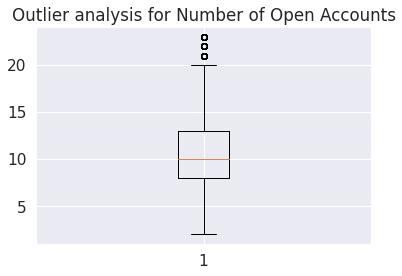

In [263]:
plt.boxplot(df_train['Number of Open Accounts'])
plt.title('Outlier analysis for Number of Open Accounts')

Text(0.5, 1.0, 'Outlier analysis for Years of Credit History')

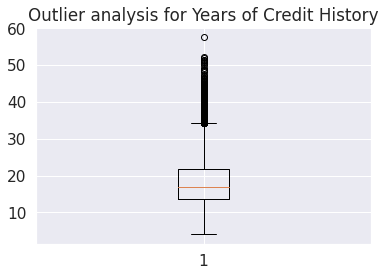

In [264]:
plt.boxplot(df_train['Years of Credit History'])
plt.title('Outlier analysis for Years of Credit History')

In [265]:
df_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: Years of Credit History, Length: 408, dtype: int64

In [266]:
replacing_outliers_with_a_median(df_train, 'Years of Credit History')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,1,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,1,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,1,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,1778920.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [267]:
df_train['Years of Credit History'].value_counts()

17.0    314
15.0    104
16.0     99
16.5     91
17.5     83
       ... 
4.9       1
4.0       1
4.3       1
31.1      1
5.3       1
Name: Years of Credit History, Length: 299, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Years of Credit History')

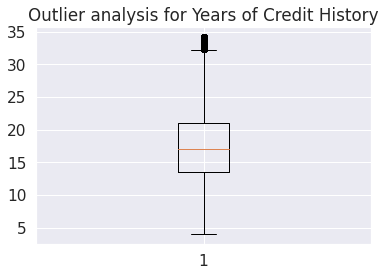

In [268]:
plt.boxplot(df_train['Years of Credit History'])
plt.title('Outlier analysis for Years of Credit History')

Text(0.5, 1.0, 'Outlier analysis for Maximum Open Credit')

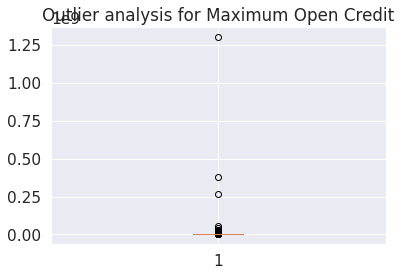

In [269]:
plt.boxplot(df_train['Maximum Open Credit'])
plt.title('Outlier analysis for Maximum Open Credit')

In [270]:
df_train['Maximum Open Credit'].value_counts()

0.0         65
319110.0     5
246224.0     3
344058.0     3
513524.0     3
            ..
668360.0     1
642224.0     1
779372.0     1
372812.0     1
480832.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [271]:
replacing_outliers_with_a_median(df_train, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,1,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,1,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,1,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [272]:
df_train['Maximum Open Credit'].value_counts()

478159.0    466
0.0          65
319110.0      5
189794.0      3
341924.0      3
           ... 
543620.0      1
383108.0      1
407506.0      1
354640.0      1
480832.0      1
Name: Maximum Open Credit, Length: 6502, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Maximum Open Credit')

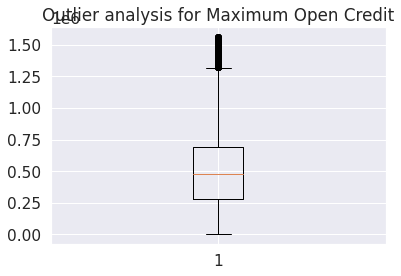

In [273]:
plt.boxplot(df_train['Maximum Open Credit'])
plt.title('Outlier analysis for Maximum Open Credit')

Text(0.5, 1.0, 'Outlier analysis for Number of Credit Problems')

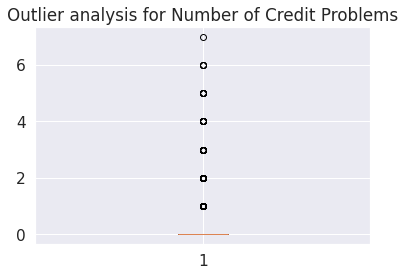

In [274]:
plt.boxplot(df_train['Number of Credit Problems'])
plt.title('Outlier analysis for Number of Credit Problems')

In [275]:
df_train['Number of Credit Problems'].value_counts()

0    6469
1     882
2      93
3      35
4       9
5       7
6       4
7       1
Name: Number of Credit Problems, dtype: int64

In [276]:
replacing_outliers_with_a_median(df_train, 'Number of Credit Problems')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [277]:
df_train['Number of Credit Problems'].value_counts()

0    7500
Name: Number of Credit Problems, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Number of Credit Problems')

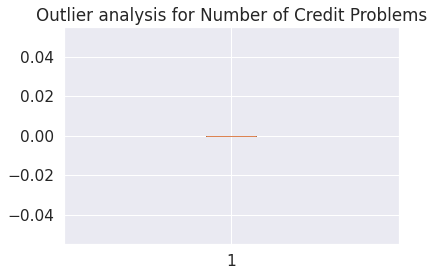

In [278]:
plt.boxplot(df_train['Number of Credit Problems'])
plt.title('Outlier analysis for Number of Credit Problems')

Text(0.5, 1.0, 'Outlier analysis for Months since last delinquent')

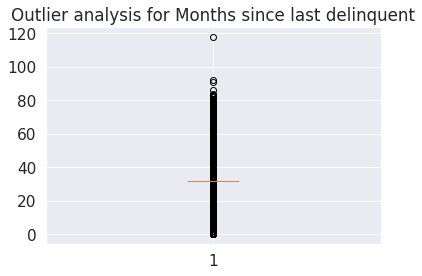

In [279]:
plt.boxplot(df_train['Months since last delinquent'])
plt.title('Outlier analysis for Months since last delinquent')

In [280]:
df_train['Months since last delinquent'].value_counts()

32.0     4132
14.0       76
29.0       71
33.0       68
8.0        68
         ... 
86.0        1
118.0       1
84.0        1
91.0        1
92.0        1
Name: Months since last delinquent, Length: 89, dtype: int64

In [281]:
replacing_outliers_with_a_median(df_train, 'Months since last delinquent')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,32.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [282]:
df_train['Months since last delinquent'].value_counts()

32.0    7500
Name: Months since last delinquent, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Months since last delinquent')

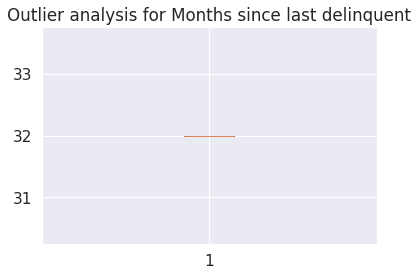

In [283]:
plt.boxplot(df_train['Months since last delinquent'])
plt.title('Outlier analysis for Months since last delinquent')

Text(0.5, 1.0, 'Outlier analysis for Bankruptcies')

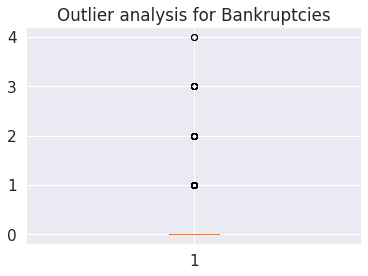

In [284]:
plt.boxplot(df_train['Bankruptcies'])
plt.title('Outlier analysis for Bankruptcies')

In [285]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [286]:
replacing_outliers_with_a_median(df_train, 'Bankruptcies')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,0.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,32.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [287]:
df_train['Bankruptcies'].value_counts()

0.0    7500
Name: Bankruptcies, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Bankruptcies')

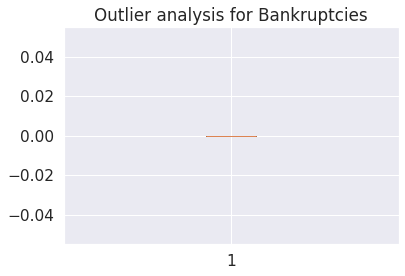

In [288]:
plt.boxplot(df_train['Bankruptcies'])
plt.title('Outlier analysis for Bankruptcies')

Text(0.5, 1.0, 'Outlier analysis for Current Loan Amount')

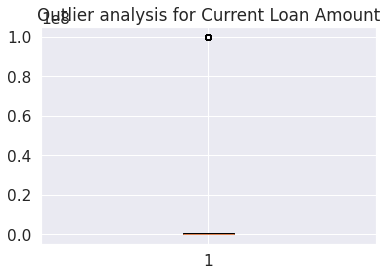

In [289]:
plt.boxplot(df_train['Current Loan Amount'])
plt.title('Outlier analysis for Current Loan Amount')

In [290]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [291]:
replacing_outliers_with_a_median(df_train, 'Current Loan Amount')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,0.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,32.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,309573.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [292]:
df_train['Current Loan Amount'].value_counts()

309573.0    870
218064.0      6
89298.0       6
222926.0      5
265826.0      5
           ... 
351626.0      1
212498.0      1
187682.0      1
108922.0      1
26928.0       1
Name: Current Loan Amount, Length: 5386, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Current Loan Amount')

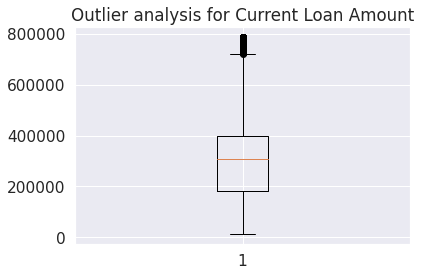

In [293]:
plt.boxplot(df_train['Current Loan Amount'])
plt.title('Outlier analysis for Current Loan Amount')

Text(0.5, 1.0, 'Outlier analysis for Current Credit Balance')

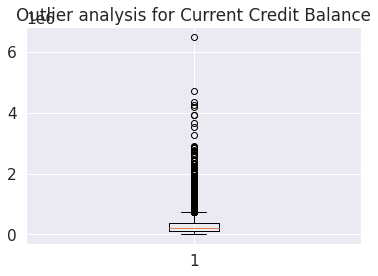

In [294]:
plt.boxplot(df_train['Current Credit Balance'])
plt.title('Outlier analysis for Current Credit Balance')

In [295]:
df_train['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
106818.0     4
83638.0      4
136401.0     4
            ..
445360.0     1
243371.0     1
25688.0      1
62054.0      1
288192.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

In [296]:
replacing_outliers_with_a_median(df_train, 'Current Credit Balance')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,0.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,32.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,309573.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [297]:
df_train['Current Credit Balance'].value_counts()

209323.0    440
0.0          53
191710.0      5
155059.0      4
83638.0       4
           ... 
134919.0      1
396834.0      1
122607.0      1
187435.0      1
288192.0      1
Name: Current Credit Balance, Length: 6159, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Current Credit Balance')

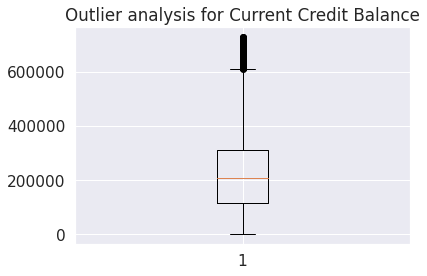

In [298]:
plt.boxplot(df_train['Current Credit Balance'])
plt.title('Outlier analysis for Current Credit Balance')

Text(0.5, 1.0, 'Outlier analysis for Monthly Debt')

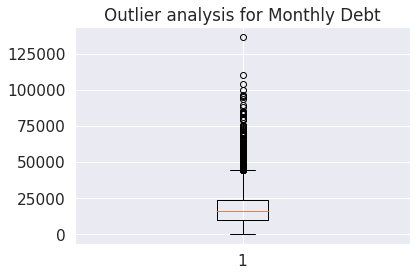

In [299]:
plt.boxplot(df_train['Monthly Debt'])
plt.title('Outlier analysis for Monthly Debt')

In [300]:
df_train['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
12986.0    3
13356.0    3
          ..
33217.0    1
8203.0     1
15150.0    1
1992.0     1
9061.0     1
Name: Monthly Debt, Length: 6716, dtype: int64

In [301]:
replacing_outliers_with_a_median(df_train, 'Monthly Debt')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,0.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,32.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,309573.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [302]:
df_train['Monthly Debt'].value_counts()

16076.5    255
0.0          6
19667.0      4
19222.0      4
11285.0      3
          ... 
940.0        1
31215.0      1
29208.0      1
19163.0      1
9061.0       1
Name: Monthly Debt, Length: 6463, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Monthly Debt')

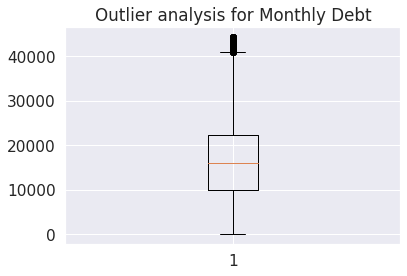

In [303]:
plt.boxplot(df_train['Monthly Debt'])
plt.title('Outlier analysis for Monthly Debt')

Text(0.5, 1.0, 'Outlier analysis for Credit Score')

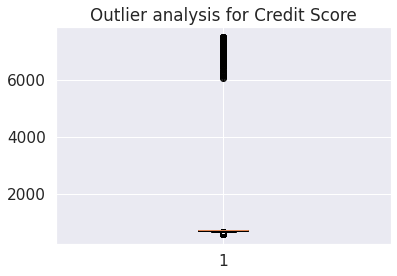

In [304]:
plt.boxplot(df_train['Credit Score'])
plt.title('Outlier analysis for Credit Score')

In [305]:
df_train['Credit Score'].value_counts()

731.0     1651
740.0      169
747.0      168
748.0      157
745.0      152
          ... 
616.0        1
6600.0       1
629.0        1
6820.0       1
6060.0       1
Name: Credit Score, Length: 268, dtype: int64

In [306]:
replacing_outliers_with_a_median(df_train, 'Credit Score')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,0.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,32.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,731.0,1
7497,Rent,1878910.0,6 years,0,12,32.1,478159.0,0,32.0,0.0,buy a car,Short Term,309573.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0,21,26.5,1141250.0,0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


In [307]:
df_train['Credit Score'].value_counts()

731.0    2654
740.0     169
747.0     168
748.0     157
745.0     152
         ... 
691.0      25
694.0      21
696.0      21
688.0      20
690.0      15
Name: Credit Score, Length: 67, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Credit Score')

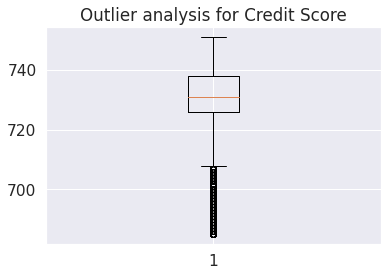

In [308]:
plt.boxplot(df_train['Credit Score'])
plt.title('Outlier analysis for Credit Score')

**Построение новых признаков**

In [309]:
df_train['Id'] = df_train.index.tolist()

**Dummies**

In [310]:
df_train['Is_Term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [311]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

**Сохраним обучающий датасет**

In [312]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

**Загрузим данные из датасетов для отбора признаков**

In [313]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df_prep = pd.read_csv(PREP_DATASET_PATH)

df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [314]:
df_prep.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0,15,15.3,1181730.0,0,32.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0,11,17.0,1182434.0,0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0,8,22.5,147400.0,0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0,13,13.6,385836.0,0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1


**Выделение целевой переменной и групп признаков**

In [315]:
df_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Id',
 'Is_Term',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 

In [316]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_prep.columns.drop([TARGET_NAME, 'Id'] + BASE_FEATURE_NAMES).tolist()

In [317]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [318]:
NEW_FEATURE_NAMES

['Is_Term',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

**Матрица корреляций**

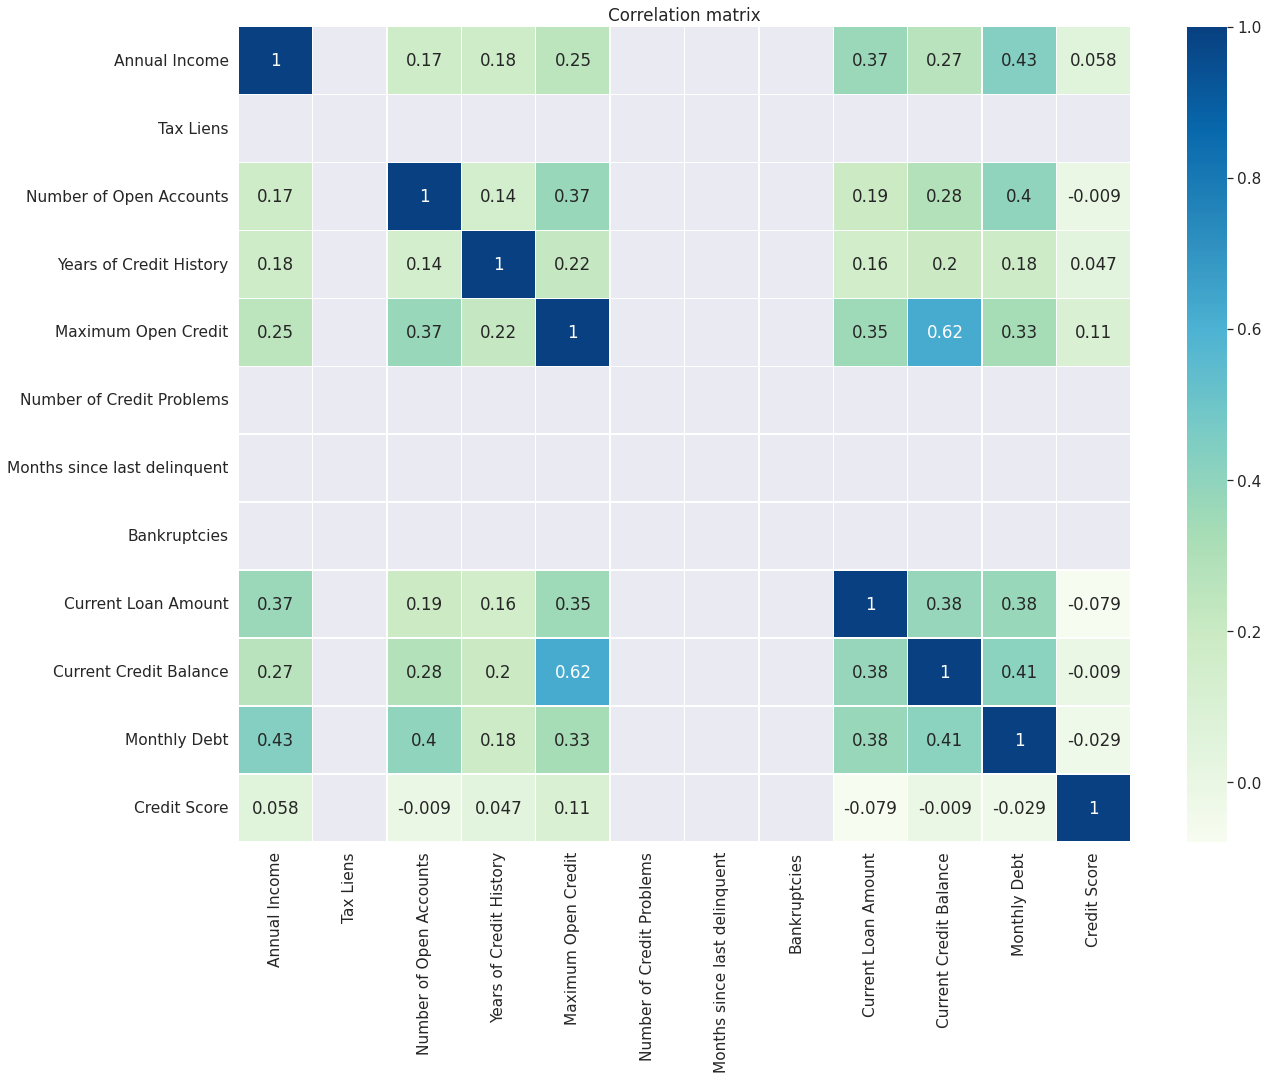

In [319]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Проверим на дисбаланс классов**

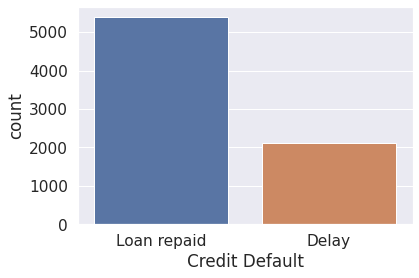

In [320]:
g = sns.countplot(df_train['Credit Default'])
g.set_xticklabels(['Loan repaid','Delay'])
plt.show()

Наблюдается дисбаланс классов, который необходимо устранить

In [321]:
# class count
class_count_0, class_count_1 = df_train['Credit Default'].value_counts()

# Separate class
class_0 = df_train[df_train['Credit Default'] == 0]
class_1 = df_train[df_train['Credit Default'] == 1]

# print the shape of the class
print('class_count_0:', class_count_0)
print(f'class_count_1: {class_count_1}', '\n')
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class_count_0: 5387
class_count_1: 2113 

class 0: (5387, 47)
class 1: (2113, 47)


**Устраним дисбаланс классов используя Random Over-Sampling**

Total class of 1 and 0: 1    5387
0    5387
Name: Credit Default, dtype: int64


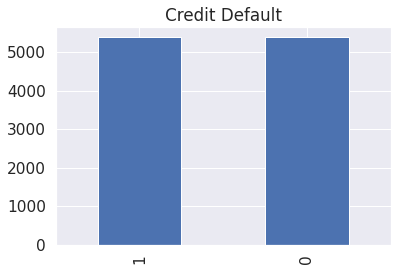

In [322]:
class_1_over = class_1.sample(5387, replace=True) # 4792

test_over = pd.concat([class_1_over, class_0], axis=0)

print("Total class of 1 and 0:",test_over['Credit Default'].value_counts())

# plot the count after Over-Sampling
test_over['Credit Default'].value_counts().plot(kind='bar', title='Credit Default');

**Отбор признаков**

In [323]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

**Приведение типов для модели CatBoost**

In [324]:
for colname in CAT_FEATURE_NAMES:
    df_prep[colname] = pd.Categorical(df_prep[colname])
    
df_prep[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

**Нормализация данных**

In [325]:
scaler = StandardScaler()

df_norm = df_prep.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_prep = df_norm.copy()

**Сохранение модели для нормализации данных**

In [326]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Разбиение на train и test**

In [327]:
X = df_prep[SELECTED_FEATURE_NAMES]
y = df_prep[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

**Балансировка целевой переменной**

In [328]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [329]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

**Сохранение обучающего и тестового датасетов**

In [330]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [331]:
df_prep.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

**Построение и оценка базовых моделей**

**Логистическая регрессия**

In [332]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3771
           1       0.60      0.40      0.48      2958

    accuracy                           0.62      6729
   macro avg       0.61      0.59      0.59      6729
weighted avg       0.61      0.62      0.60      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1616
           1       0.42      0.38      0.40       634

    accuracy                           0.68      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.67      0.68      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1281  335
1                391  243


**k-ближайших соседей**

In [333]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3771
           1       0.73      0.68      0.70      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.74      0.74      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1616
           1       0.36      0.42      0.39       634

    accuracy                           0.62      2250
   macro avg       0.56      0.56      0.56      2250
weighted avg       0.64      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1136  480
1                366  268


**XGBoost**

In [334]:
# model_xgb = xgb.XGBClassifier(random_state=21)
# model_xgb.fit(X_train, y_train)

# y_train_pred = model_xgb.predict(X_train)
# y_test_pred = model_xgb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

**LightGBM**

In [335]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3771
           1       0.89      0.90      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1616
           1       0.48      0.49      0.48       634

    accuracy                           0.71      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.71      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1278  338
1                324  310


**CatBoost**

In [336]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3771
           1       0.88      0.85      0.87      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.88      0.88      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1616
           1       0.50      0.50      0.50       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1297  319
1                314  320


**Выбор лучшей модели и подбор гиперпараметров**

In [337]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [338]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [339]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [560]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 10.7 s, sys: 1.4 s, total: 12.1 s
Wall time: 2min 10s


In [561]:
rs.best_params_

{'max_depth': 5, 'n_estimators': 1500}

In [562]:
rs.best_score_

0.5352526400119096

**Обучение и оценка финальной модели**

In [563]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      3771
           1       0.76      0.67      0.71      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.75      0.75      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1616
           1       0.49      0.56      0.53       634

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1250  366
1                277  357
CPU times: user 2.05 s, sys: 350 ms, total: 2.4 s
Wall time: 2.24 s


**Важность признаков**

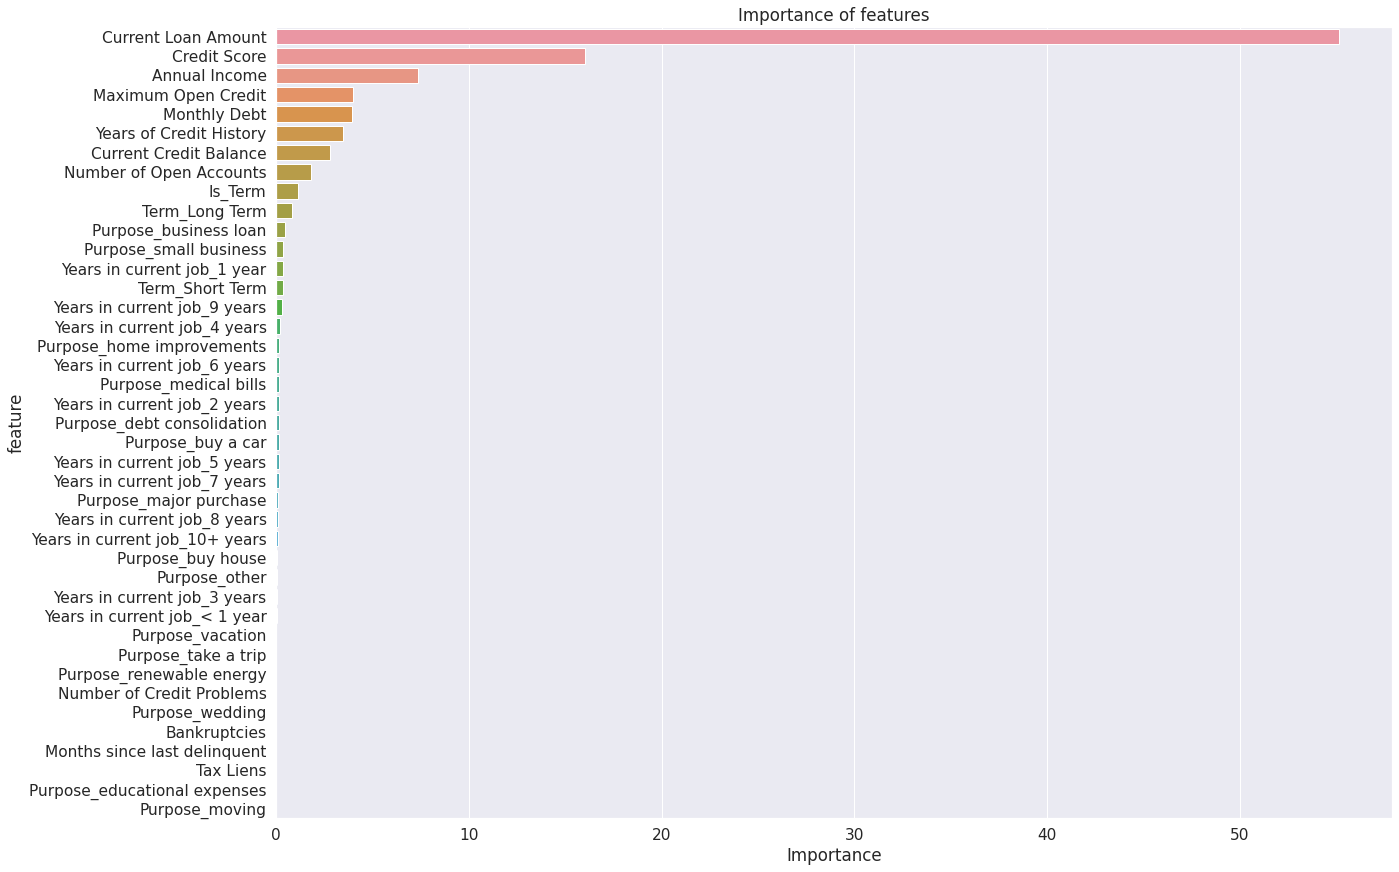

In [564]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [565]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Is_Term',
 'Term_Long Term',
 'Purpose_business loan',
 'Purpose_small business',
 'Years in current job_1 year',
 'Term_Short Term',
 'Years in current job_9 years']

**ФИНАЛЬНАЯ МОДЕЛЬ**

In [566]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=3, l2_leaf_reg=5,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.82      0.79      3771
           1       0.74      0.65      0.70      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.74      0.74      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1616
           1       0.49      0.57      0.53       634

    accuracy                           0.71      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1242  374
1                275  359


**Сохранение финальной модели**

In [567]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

**Выполним для тестового датасета те же этапы обработки и построения признаков, что и для обучающего**

In [568]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
209,Rent,769956.0,< 1 year,0.0,6.0,15.5,737748.0,1.0,NaN,1.0,debt consolidation,Short Term,289740.0,63707.0,8983.0,728.0
966,Home Mortgage,2266776.0,10+ years,0.0,17.0,17.2,616550.0,0.0,NaN,0.0,other,Short Term,99999999.0,489877.0,34908.0,736.0
1111,Home Mortgage,680827.0,10+ years,0.0,14.0,37.0,360118.0,1.0,NaN,1.0,debt consolidation,Short Term,252274.0,103569.0,12198.0,722.0
1417,Rent,NaN,6 years,0.0,11.0,24.5,382954.0,1.0,NaN,1.0,other,Short Term,255376.0,127984.0,15395.0,NaN
2258,Rent,NaN,7 years,0.0,12.0,25.5,837012.0,0.0,3.0,0.0,debt consolidation,Short Term,265232.0,202407.0,26709.0,NaN


In [569]:
df_test.shape

(2500, 16)

In [570]:
df_test.iloc[906]

Home Ownership                                Rent
Annual Income                             381900.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                        2.0
Years of Credit History                       16.0
Maximum Open Credit                        22088.0
Number of Credit Problems                      0.0
Months since last delinquent                  18.0
Bankruptcies                                   0.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                        43054.0
Current Credit Balance                     10735.0
Monthly Debt                                8720.0
Credit Score                                7110.0
Name: 906, dtype: object

In [571]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Приведение типов

In [572]:
for colname in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems']:
  df_test[colname] = df_test[colname].astype(int)

In [573]:
df_test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                         int64
Number of Open Accounts           int64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems         int64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

Обзор количественных признаков

In [574]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


Обзор номинативных признаков

In [575]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

Обработка пропусков

In [576]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Подсчитаем пропуски в процентах

In [577]:
percentage_missing(df_test, 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score')

Missing data in feature "Annual Income" are 20.52%
Missing data in feature "Years in current job" are 3.44%
Missing data in feature "Months since last delinquent" are 54.32%
Missing data in feature "Bankruptcies" are 0.12%
Missing data in feature "Credit Score" are 20.52%


Заполним медианой пропуски в числовых признаках

In [578]:
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Annual Income'].median()

df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] \
           = df_test['Months since last delinquent'].median()

df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = df_test['Bankruptcies'].median()

df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = df_test['Credit Score'].median()

Заполним модой пропуски в категориальных признаках

In [579]:
df_test['Years in current job'].mode()[0]

'10+ years'

In [580]:
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job']

60      NaN
98      NaN
108     NaN
204     NaN
236     NaN
       ... 
2352    NaN
2367    NaN
2402    NaN
2413    NaN
2464    NaN
Name: Years in current job, Length: 86, dtype: object

In [581]:
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [582]:
df_test['Years in current job'].isna().sum()

0

Проверим датасет на пропуски

In [583]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

Поработаем с выбросами

Text(0.5, 1.0, 'Outlier analysis for Annual Income')

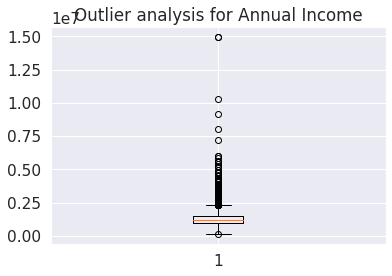

In [584]:
plt.boxplot(df_test['Annual Income'])
plt.title('Outlier analysis for Annual Income')

In [585]:
df_test['Annual Income'].value_counts()

1178475.0    514
1214993.0      3
1025145.0      3
1237109.0      3
1328803.0      3
            ... 
1221168.0      1
651377.0       1
1735479.0      1
1864090.0      1
1694439.0      1
Name: Annual Income, Length: 1929, dtype: int64

Подсчитаем границы выбросов по квантилям методом IQR

In [586]:
replacing_outliers_with_a_median(df_test, 'Annual Income')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,1,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,1737780.0,0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,48,12.8,1706430.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [587]:
df_test['Annual Income'].value_counts()

1178475.0    690
1025145.0      3
1214993.0      3
1328803.0      3
1237109.0      3
            ... 
651377.0       1
1735479.0      1
1864090.0      1
1727442.0      1
1694439.0      1
Name: Annual Income, Length: 1753, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Annual Income')

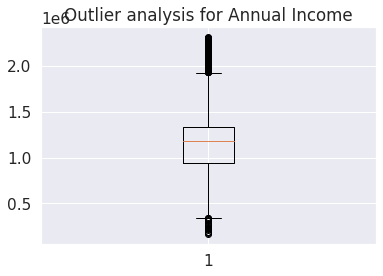

In [588]:
plt.boxplot(df_test['Annual Income'])
plt.title('Outlier analysis for Annual Income')

Text(0.5, 1.0, 'Outlier analysis for Tax Liens')

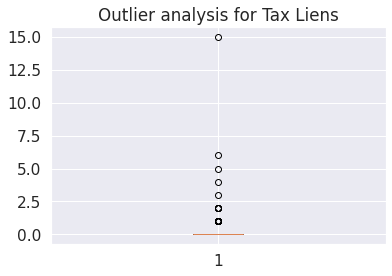

In [589]:
plt.boxplot(df_test['Tax Liens'])
plt.title('Outlier analysis for Tax Liens')

In [590]:
df_test['Tax Liens'].value_counts()

0     2445
1       45
2        5
5        1
4        1
6        1
3        1
15       1
Name: Tax Liens, dtype: int64

In [591]:
replacing_outliers_with_a_median(df_test, 'Tax Liens')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,1,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,1737780.0,0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,48,12.8,1706430.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [592]:
df_test['Tax Liens'].value_counts()

0    2500
Name: Tax Liens, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Tax Liens')

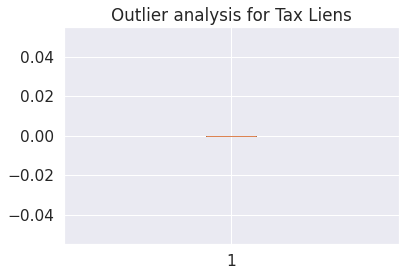

In [593]:
plt.boxplot(df_test['Tax Liens'])
plt.title('Outlier analysis for Tax Liens')

Text(0.5, 1.0, 'Outlier analysis for Number of Open Accounts')

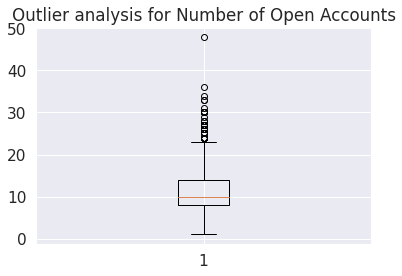

In [594]:
plt.boxplot(df_test['Number of Open Accounts'])
plt.title('Outlier analysis for Number of Open Accounts')

In [595]:
df_test['Number of Open Accounts'].value_counts()

9     245
8     223
10    218
11    211
12    204
6     183
13    178
7     176
14    159
5     106
15     97
16     81
17     66
4      63
18     52
19     46
20     37
21     29
3      29
22     26
23     17
27     10
24      9
2       7
30      6
25      6
26      5
28      3
33      2
31      1
1       1
36      1
29      1
34      1
48      1
Name: Number of Open Accounts, dtype: int64

In [596]:
replacing_outliers_with_a_median(df_test, 'Number of Open Accounts')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,1,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,1737780.0,0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,1706430.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [597]:
df_test['Number of Open Accounts'].value_counts()

10    264
9     245
8     223
11    211
12    204
6     183
13    178
7     176
14    159
5     106
15     97
16     81
17     66
4      63
18     52
19     46
20     37
21     29
3      29
22     26
23     17
2       7
1       1
Name: Number of Open Accounts, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Number of Open Accounts')

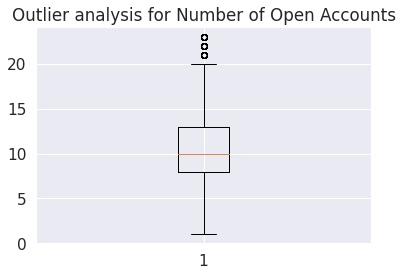

In [598]:
plt.boxplot(df_test['Number of Open Accounts'])
plt.title('Outlier analysis for Number of Open Accounts')

Text(0.5, 1.0, 'Outlier analysis for Years of Credit History')

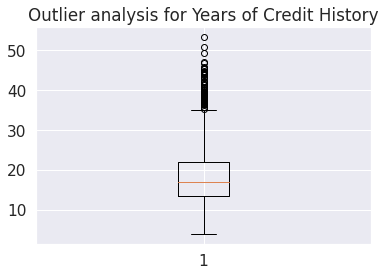

In [599]:
plt.boxplot(df_test['Years of Credit History'])
plt.title('Outlier analysis for Years of Credit History')

In [600]:
df_test['Years of Credit History'].value_counts()

16.5    35
14.0    33
16.0    32
17.0    30
17.5    28
        ..
53.4     1
38.2     1
5.6      1
29.6     1
45.6     1
Name: Years of Credit History, Length: 345, dtype: int64

In [601]:
replacing_outliers_with_a_median(df_test, 'Years of Credit History')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,1,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,1737780.0,0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,1706430.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [602]:
df_test['Years of Credit History'].value_counts()

17.0    100
16.5     35
14.0     33
16.0     32
15.4     28
       ... 
35.0      1
5.6       1
29.6      1
33.8      1
7.3       1
Name: Years of Credit History, Length: 299, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Years of Credit History')

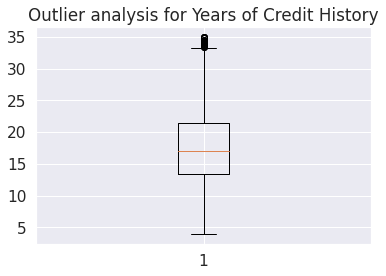

In [603]:
plt.boxplot(df_test['Years of Credit History'])
plt.title('Outlier analysis for Years of Credit History')

Text(0.5, 1.0, 'Outlier analysis for Maximum Open Credit')

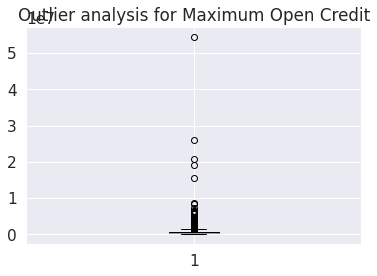

In [604]:
plt.boxplot(df_test['Maximum Open Credit'])
plt.title('Outlier analysis for Maximum Open Credit')

In [605]:
df_test['Maximum Open Credit'].value_counts()

0.0          14
220968.0      2
674344.0      2
1138478.0     2
437228.0      2
             ..
181764.0      1
604406.0      1
248512.0      1
215666.0      1
1199748.0     1
Name: Maximum Open Credit, Length: 2435, dtype: int64

In [606]:
replacing_outliers_with_a_median(df_test, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,1,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [607]:
df_test['Maximum Open Credit'].value_counts()

478676.0     156
0.0           14
207218.0       2
432190.0       2
196064.0       2
            ... 
347358.0       1
679382.0       1
572242.0       1
602734.0       1
1199748.0      1
Name: Maximum Open Credit, Length: 2281, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Maximum Open Credit')

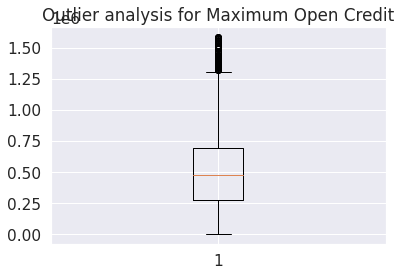

In [608]:
plt.boxplot(df_test['Maximum Open Credit'])
plt.title('Outlier analysis for Maximum Open Credit')

Text(0.5, 1.0, 'Outlier analysis for Number of Credit Problems')

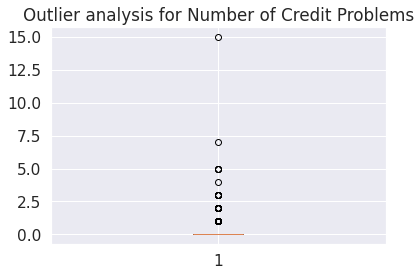

In [609]:
plt.boxplot(df_test['Number of Credit Problems'])
plt.title('Outlier analysis for Number of Credit Problems')

In [610]:
df_test['Number of Credit Problems'].value_counts()

0     2177
1      280
2       29
3        7
5        4
7        1
4        1
15       1
Name: Number of Credit Problems, dtype: int64

In [611]:
replacing_outliers_with_a_median(df_test, 'Number of Credit Problems')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [612]:
df_test['Number of Credit Problems'].value_counts()

0    2500
Name: Number of Credit Problems, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Number of Credit Problems')

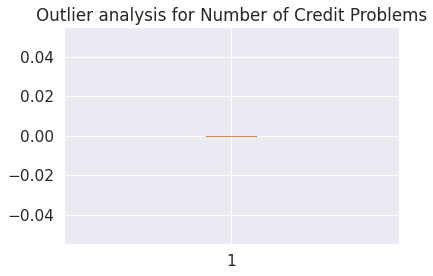

In [613]:
plt.boxplot(df_test['Number of Credit Problems'])
plt.title('Outlier analysis for Number of Credit Problems')

Text(0.5, 1.0, 'Outlier analysis for Months since last delinquent')

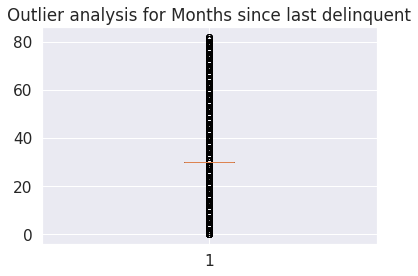

In [614]:
plt.boxplot(df_test['Months since last delinquent'])
plt.title('Outlier analysis for Months since last delinquent')

In [615]:
df_test['Months since last delinquent'].value_counts()

30.0    1375
16.0      30
14.0      28
23.0      28
24.0      26
        ... 
64.0       5
81.0       5
65.0       5
60.0       5
82.0       3
Name: Months since last delinquent, Length: 83, dtype: int64

In [616]:
replacing_outliers_with_a_median(df_test, 'Months since last delinquent')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,30.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,30.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [617]:
df_test['Months since last delinquent'].value_counts()

30.0    2500
Name: Months since last delinquent, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Months since last delinquent')

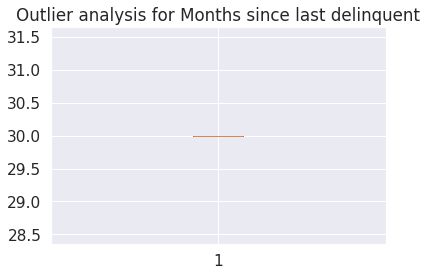

In [618]:
plt.boxplot(df_test['Months since last delinquent'])
plt.title('Outlier analysis for Months since last delinquent')

Text(0.5, 1.0, 'Outlier analysis for Bankruptcies')

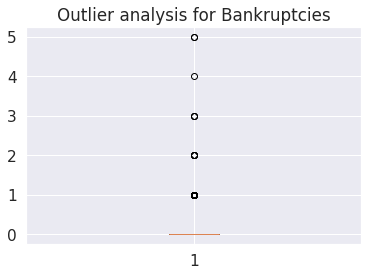

In [619]:
plt.boxplot(df_test['Bankruptcies'])
plt.title('Outlier analysis for Bankruptcies')

In [620]:
df_test['Bankruptcies'].value_counts()

0.0    2255
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [621]:
replacing_outliers_with_a_median(df_test, 'Bankruptcies')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,30.0,0.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,30.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [622]:
df_test['Bankruptcies'].value_counts()

0.0    2500
Name: Bankruptcies, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Bankruptcies')

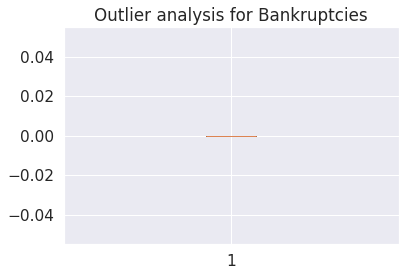

In [623]:
plt.boxplot(df_test['Bankruptcies'])
plt.title('Outlier analysis for Bankruptcies')

Text(0.5, 1.0, 'Outlier analysis for Current Loan Amount')

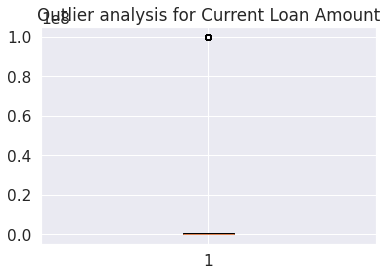

In [624]:
plt.boxplot(df_test['Current Loan Amount'])
plt.title('Outlier analysis for Current Loan Amount')

In [625]:
df_test['Current Loan Amount'].value_counts()

99999999.0    297
269544.0        3
264638.0        3
327404.0        3
110462.0        3
             ... 
445016.0        1
142824.0        1
494010.0        1
439472.0        1
763004.0        1
Name: Current Loan Amount, Length: 2026, dtype: int64

In [626]:
replacing_outliers_with_a_median(df_test, 'Current Loan Amount')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,30.0,0.0,debt consolidation,Short Term,322366.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,30.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [627]:
df_test['Current Loan Amount'].value_counts()

322366.0    297
269544.0      3
264638.0      3
327404.0      3
110462.0      3
           ... 
445016.0      1
142824.0      1
494010.0      1
439472.0      1
763004.0      1
Name: Current Loan Amount, Length: 2026, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Current Loan Amount')

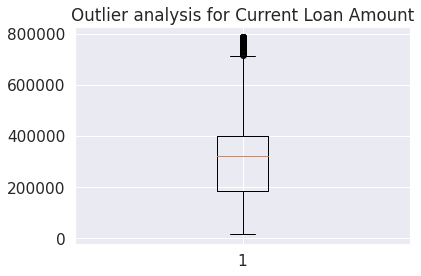

In [628]:
plt.boxplot(df_test['Current Loan Amount'])
plt.title('Outlier analysis for Current Loan Amount')

Text(0.5, 1.0, 'Outlier analysis for Current Credit Balance')

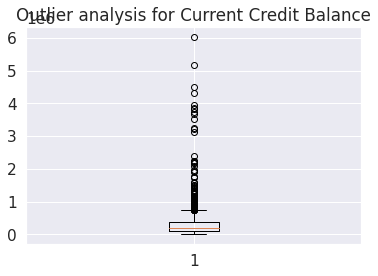

In [629]:
plt.boxplot(df_test['Current Credit Balance'])
plt.title('Outlier analysis for Current Credit Balance')

In [630]:
df_test['Current Credit Balance'].value_counts()

0.0         11
169917.0     4
153064.0     3
109440.0     3
93936.0      3
            ..
21508.0      1
103455.0     1
786448.0     1
37829.0      1
559531.0     1
Name: Current Credit Balance, Length: 2385, dtype: int64

In [631]:
replacing_outliers_with_a_median(df_test, 'Current Credit Balance')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,30.0,0.0,debt consolidation,Short Term,322366.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,30.0,0.0,debt consolidation,Short Term,468512.0,207385.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [632]:
df_test['Current Credit Balance'].value_counts()

207385.0    125
0.0          11
169917.0      4
153064.0      3
109440.0      3
           ... 
104766.0      1
70148.0       1
75981.0       1
158346.0      1
559531.0      1
Name: Current Credit Balance, Length: 2261, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Current Credit Balance')

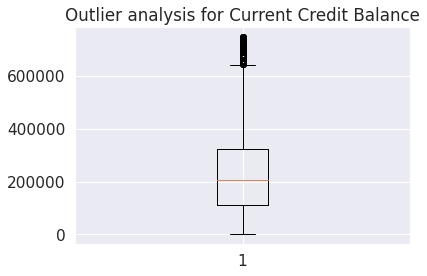

In [633]:
plt.boxplot(df_test['Current Credit Balance'])
plt.title('Outlier analysis for Current Credit Balance')

Text(0.5, 1.0, 'Outlier analysis for Monthly Debt')

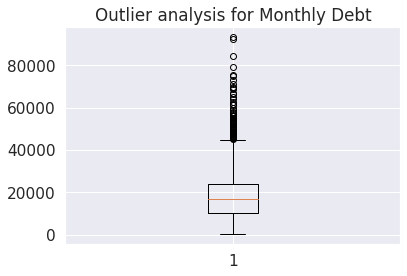

In [634]:
plt.boxplot(df_test['Monthly Debt'])
plt.title('Outlier analysis for Monthly Debt')

In [635]:
df_test['Monthly Debt'].value_counts()

24146.0    3
23239.0    2
17789.0    2
28119.0    2
32198.0    2
          ..
11273.0    1
18352.0    1
25457.0    1
11178.0    1
23440.0    1
Name: Monthly Debt, Length: 2416, dtype: int64

In [636]:
replacing_outliers_with_a_median(df_test, 'Monthly Debt')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,30.0,0.0,debt consolidation,Short Term,322366.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,30.0,0.0,debt consolidation,Short Term,468512.0,207385.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [637]:
df_test['Monthly Debt'].value_counts()

16642.5    69
24146.0     3
23691.0     2
25964.0     2
24199.0     2
           ..
20494.0     1
37929.0     1
23087.0     1
2421.0      1
23440.0     1
Name: Monthly Debt, Length: 2348, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Monthly Debt')

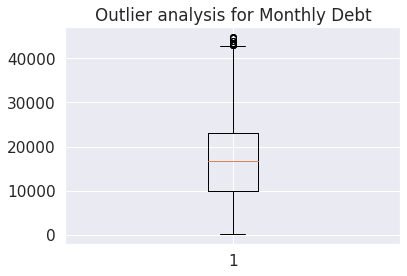

In [638]:
plt.boxplot(df_test['Monthly Debt'])
plt.title('Outlier analysis for Monthly Debt')

Text(0.5, 1.0, 'Outlier analysis for Credit Score')

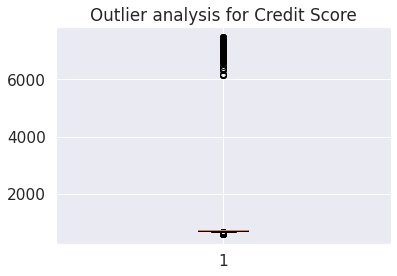

In [639]:
plt.boxplot(df_test['Credit Score'])
plt.title('Outlier analysis for Credit Score')

In [640]:
df_train['Credit Score'].value_counts()

731.0    2654
740.0     169
747.0     168
748.0     157
745.0     152
         ... 
691.0      25
694.0      21
696.0      21
688.0      20
690.0      15
Name: Credit Score, Length: 67, dtype: int64

In [641]:
replacing_outliers_with_a_median(df_test, 'Credit Score')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,731.0
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,0,30.0,0.0,debt consolidation,Short Term,322366.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2 years,0,15,17.0,478676.0,0,30.0,0.0,debt consolidation,Short Term,468512.0,207385.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2 years,0,10,12.8,478676.0,0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [642]:
df_train['Credit Score'].value_counts()

731.0    2654
740.0     169
747.0     168
748.0     157
745.0     152
         ... 
691.0      25
694.0      21
696.0      21
688.0      20
690.0      15
Name: Credit Score, Length: 67, dtype: int64

Text(0.5, 1.0, 'Outlier analysis for Credit Score')

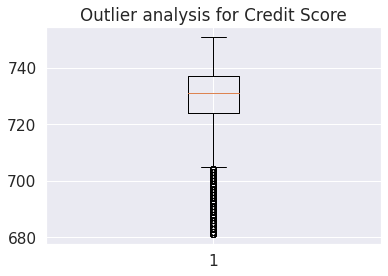

In [643]:
plt.boxplot(df_test['Credit Score'])
plt.title('Outlier analysis for Credit Score')

Построение новых признаков

In [644]:
df_test['Id'] = df_test.index.tolist()

Dummies

In [645]:
df_test['Is_Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [646]:
for cat_colname in df_test.select_dtypes(include='object').columns[1:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

Сохраним тестовый датасет

In [647]:
df_test.to_csv(PREP_TEST_DATASET_PATH, index=False, encoding='utf-8')

Сохраним данные из датасетов для отбора признаков

In [648]:
df_base_test = pd.read_csv(TEST_DATASET_PATH)
df_prep_test = pd.read_csv(PREP_TEST_DATASET_PATH)

df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [649]:
df_prep_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Rent,1178475.0,4 years,0,9,12.5,220968.0,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,Rent,231838.0,1 year,0,6,32.7,55946.0,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,Home Mortgage,1152540.0,3 years,0,10,13.7,204600.0,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Home Mortgage,1220313.0,10+ years,0,16,17.0,456302.0,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,Home Mortgage,1178475.0,6 years,0,11,23.6,1207272.0,0,30.0,0.0,...,0,0,0,0,0,0,0,0,1,0


Выделение целевой переменной и групп признаков

In [650]:
df_test.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Id',
 'Is_Term',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small busi

In [651]:
# TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES_TEST = df_base_test.columns.tolist()
NEW_FEATURE_NAMES_TEST = df_prep_test.columns.drop(['Id'] + BASE_FEATURE_NAMES_TEST).tolist()

In [652]:
BASE_FEATURE_NAMES_TEST

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [653]:
NEW_FEATURE_NAMES_TEST

['Is_Term',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

Матрица корреляций

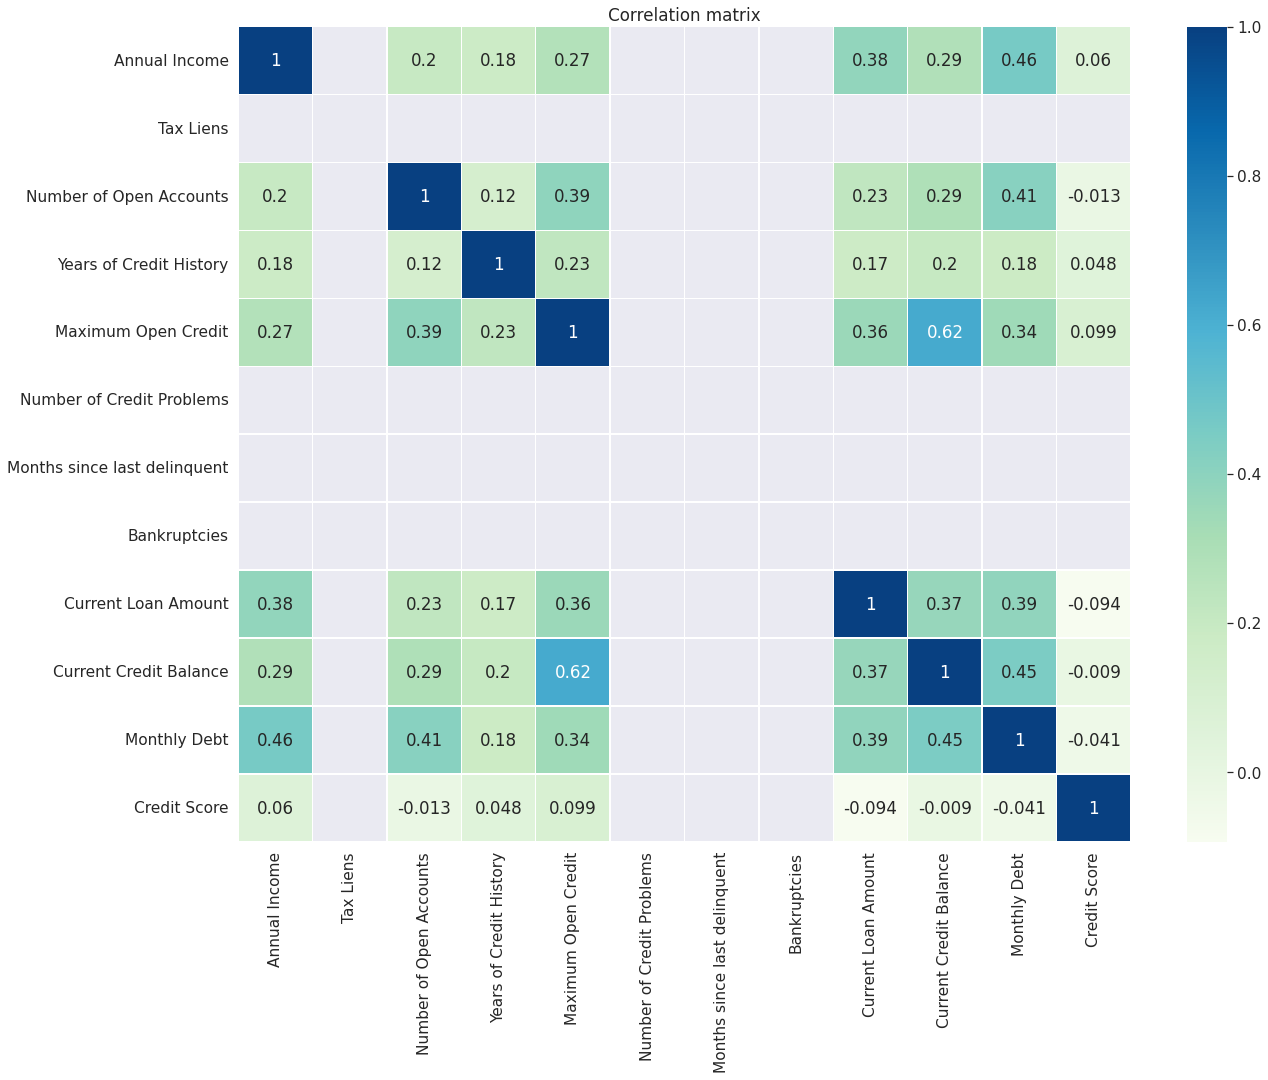

In [654]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_test[BASE_FEATURE_NAMES_TEST].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Отбор признаков

In [655]:
NUM_FEATURE_NAMES_TEST = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES_TEST = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES_TEST = NUM_FEATURE_NAMES_TEST + NEW_FEATURE_NAMES_TEST

Приведение типов для модели CatBoost

In [656]:
for colname in CAT_FEATURE_NAMES_TEST:
    df_prep_test[colname] = pd.Categorical(df_prep_test[colname])
    
df_prep_test[CAT_FEATURE_NAMES_TEST].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

Нормализация данных

In [657]:
scaler_test = StandardScaler()

df_norm_test = df_prep_test.copy()
df_norm_test[NUM_FEATURE_NAMES_TEST] = scaler_test.fit_transform(df_norm_test[NUM_FEATURE_NAMES_TEST])

df_prep_test = df_norm_test.copy()

In [658]:
data_test = df_prep_test[SELECTED_FEATURE_NAMES_TEST]

**ПРОГНОЗИРОВАНИЕ НА ТЕСТОВОМ ДАТАСЕТЕ**

In [659]:
df_test_pred = final_model.predict(data_test)
df_test_pred

array([0, 0, 0, ..., 0, 0, 1])

Сохранение в файл .csv

In [660]:
pd.DataFrame(df_test_pred).to_csv(PREDICT_TEST_PATH)